# Лабораторная работа №4. Реализация приложения по распознаванию номеров домов.

**Данные:**

Набор изображений из Google Street View с изображениями номеров домов, содержащий 10 классов, соответствующих цифрам от 0 до 9.
    - 73257 изображений цифр в обучающей выборке;
    - 26032 изображения цифр в тестовой выборке;
    - 531131 изображения, которые можно использовать как дополнение к обучающей выборке;

В двух форматах:
    - Оригинальные изображения с выделенными цифрами;
    - Изображения размером 32 × 32, содержащих одну цифру;

Данные первого формата можно скачать по ссылкам:
    o   http://ufldl.stanford.edu/housenumbers/train.tar.gz (обучающая выборка);
    o   http://ufldl.stanford.edu/housenumbers/test.tar.gz (тестовая выборка);
    o   http://ufldl.stanford.edu/housenumbers/extra.tar.gz (дополнительные данные);

Данные второго формата можно скачать по ссылкам:
    o   http://ufldl.stanford.edu/housenumbers/train_32x32.mat (обучающая выборка);
    o   http://ufldl.stanford.edu/housenumbers/test_32x32.mat (тестовая выборка);
    o   http://ufldl.stanford.edu/housenumbers/extra_32x32.mat (дополнительные данные);

Описание данных на английском языке доступно по ссылке:
    o   http://ufldl.stanford.edu/housenumbers/


In [0]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pathlib
import random
import os
import pdb

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

In [0]:
DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/4/'

#### Tensorflow model wrapper

In [0]:
import random
import datetime

class Model:
    EPOCH_COUNT = 10
    
    def __init__(self, layers=[], model=None, optimizer=None, loss='sparse_categorical_crossentropy'):
        self.layers = layers
        self.model = model
        self.loss = loss
        self.optimizer = optimizer or tf.keras.optimizers.SGD(learning_rate=0.1)
        if not self.model:
            self.initialize()
        print('----------------------------------------------------------------------------------------')
        print(self.summary())
        print('----------------------------------------------------------------------------------------')

    def initialize(self):
        self.model = tf.keras.models.Sequential(self.layers)
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])

    # only for initialized models
    def compile(self, loss='sparse_categorical_crossentropy', optimizer=None, metrics=['accuracy']):
        loss = loss or self.loss
        optimizer = optimizer or self.optimizer
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        
    def _train_on_batches(self, iterator, batch_count, epochs=None, **kwargs):
        epochs = epochs or self.EPOCH_COUNT
        loss, tran_accuracy, val_loss, val_accuracy = np.zeros((4, batch_count, epochs))

        for i in range(batch_count):
            print('----------------------------------------------------------------------------------------')
            print(f'Train on batch #{i}')
            print('----------------------------------------------------------------------------------------')
            x, y = next(iterator)
            batch_history = self.model.fit(x,  y, epochs=epochs, **kwargs)
            loss[i, :] = batch_history.history['loss']
            tran_accuracy[i, :] = batch_history.history['accuracy']
            if batch_history.history.get('val_accuracy'):
                val_accuracy[i, :] = batch_history.history.get('val_accuracy')[-1]
            if batch_history.history.get('val_loss'):
                val_loss[i, :] = batch_history.history.get('val_loss')[-1]

        val_loss = val_loss if np.any(val_loss) else None
        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_loss, val_accuracy

    def _train_on_full_data(self, iterator, y=None, epochs=None, **kwargs):
        print('----------------------------------------------------------------------------------------')
        print(f'Train on full data')
        print('----------------------------------------------------------------------------------------')
        epochs = epochs or self.EPOCH_COUNT
        history = self.model.fit(iterator, y, epochs=epochs, **kwargs)
        loss = np.array([history.history['loss']])
        tran_accuracy = np.array([history.history['accuracy']])
        val_loss = np.array([history.history.get('val_loss')])
        val_accuracy = np.array([history.history.get('val_accuracy')])

        val_loss = val_loss if np.any(val_loss) else None
        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_loss, val_accuracy

    def _plot_train_accuracy_graphs(self, loss, tran_accuracy, validation_loss=[], validation_accuracy=[], mode='batch'):
        print('----------------------------------------------------------------------------------------')
        if mode == 'batch':
            plt.figure(figsize=(15, 12))
            ax_shape = (2, 2)
        else:
            plt.figure(figsize=(15,5))
            ax_shape = (1, 2)

        xlabel = 'Epochs'
        ax = plt.subplot(*ax_shape, 1)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Loss', fontsize=14)

        epochs_loss = np.average(loss, axis=0)
        ax.plot(epochs_loss)
        if np.any(validation_loss):
            val_epochs_loss = np.average(validation_loss, axis=0)
            ax.plot(val_epochs_loss, '--')


        ax = plt.subplot(*ax_shape, 2)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)

        epochs_accuracy = np.average(tran_accuracy, axis=0)
        ax.plot(epochs_accuracy)
        if np.any(validation_accuracy):
            val_epochs_accuracy = np.average(validation_accuracy, axis=0)
            ax.plot(val_epochs_accuracy, '--')

        if mode == 'batch':
            xlabel = 'Batches'
            ax = plt.subplot(*ax_shape, 3)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Loss', fontsize=14)

            batches_loss = np.average(loss, axis=1)
            ax.plot(batches_loss)
            if np.any(validation_loss):
                val_batches_loss = np.average(validation_loss, axis=1)
                ax.plot(val_batches_loss, '--')

            ax = plt.subplot(*ax_shape, 4)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Accuracy', fontsize=14)

            batches_accuracy = np.average(tran_accuracy, axis=1)
            ax.plot(batches_accuracy)
            if np.any(validation_accuracy):
                val_batches_accuracy = np.average(validation_accuracy, axis=1)
                ax.plot(val_batches_accuracy, '--')
        
        plt.show()

    def _show_train_result(self, spent_time, average_loss, average_tran_accuracy, val_loss=None, val_accuracy=None):
        print('----------------------------------------------------------------------------------------')
        print('Spent time:', spent_time)
        print('Average loss error:', average_loss)
        print('Average train error:', average_tran_accuracy)
        if val_loss is not None:
            print('Average validation loss error:', val_loss)
        if val_accuracy is not None:
            print('Average validation error:', val_accuracy)
        print('----------------------------------------------------------------------------------------')

    def train(self, x, y=None, batch_count=None, show_accuracy_graph=True, **kwargs):
        now = datetime.datetime.now()
        val_accuracy = []

        if batch_count:
            loss, tran_accuracy, val_loss, val_accuracy =  self._train_on_batches(x, batch_count, **kwargs)
        else:
            print('----------------------------------------------------------------------------------------')
            print(f'Started at {now}')
            loss, tran_accuracy, val_loss, val_accuracy =  self._train_on_full_data(x, y, **kwargs)

        if show_accuracy_graph:
            mode = 'batch' if batch_count else 'epoch'
            self._plot_train_accuracy_graphs(loss, tran_accuracy, val_loss, val_accuracy, mode=mode)

        average_loss = np.average(loss)
        average_tran_accuracy = np.average(tran_accuracy)
        average_val_loss = np.any(val_loss) and np.average(val_loss)
        average_val_accuracy = np.any(val_accuracy) and np.average(val_accuracy)
        self._show_train_result(
            datetime.datetime.now() - now,
            average_loss,
            average_tran_accuracy,
            average_val_loss,
            average_val_accuracy
        )

        return {'loss': loss, 'accuracy': tran_accuracy, 'val_accuracy': val_accuracy}

    def test(self, x_test, y_test=None, **kwargs):
        return self.model.evaluate(x_test,  y_test, **kwargs)
    
    def summary(self):
        return self.model.summary()

    def predict(self, data, **kwargs):
        return self.model.predict(data, **kwargs)

    def save(self, **kwargs):
        filedir = kwargs.pop('filedir', './')
        filepath = filedir + kwargs.pop('filename', self.model.name)
        tf.keras.models.save_model(self.model, filepath, **kwargs)

### Задание 1. Реализуйте глубокую нейронную сеть (полносвязную или сверточную) и обучите ее на синтетических данных (например, наборы MNIST (http://yann.lecun.com/exdb/mnist/) или notMNIST).


Загрузим и подготовим данные.

In [46]:
!pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.2-cp36-none-any.whl size=8032 sha256=e2802ea9b6dd5a4d61a6c14001c075ecff3925f55c923218b07f222c9c72fb6e
  Stored in directory: /root/.cache/pip/wheels/7a/b5/69/3e0757b3086607e95db70661798fdf98a77a0bb79c54e1f320
Successfully built idx2numpy


In [0]:
import idx2numpy, cv2
import numpy as np

TRAIN_DATA_FILENAME = 'train-images-idx3-ubyte'
TRAIN_LABELS_FILENAME = 'train-labels-idx1-ubyte'
TEST_DATA_FILENAME = 't10k-images-idx3-ubyte'
TEST_LABELS_FILENAME = 't10k-labels-idx1-ubyte'

In [0]:
def create_image_dataset(data_filename, labels_filename ):
    data = idx2numpy.convert_from_file(f'{DRIVE_DIR}{data_filename}')
    data = np.reshape(data, (*data.shape, 1))
    labels = idx2numpy.convert_from_file(f'{DRIVE_DIR}{labels_filename}')

    print('Image shape:', data.shape)
    print('Labels shape:', labels.shape)
    return (data, labels)


In [49]:
train_dataset = create_image_dataset(TRAIN_DATA_FILENAME, TRAIN_LABELS_FILENAME)
test_dataset = create_image_dataset(TEST_DATA_FILENAME, TEST_LABELS_FILENAME)

Image shape: (60000, 28, 28, 1)
Labels shape: (60000,)
Image shape: (10000, 28, 28, 1)
Labels shape: (10000,)


In [50]:
set(list(test_dataset[1]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [0]:
def show_images(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    data, labels = dataset
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(data[i, :, :, 0], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')

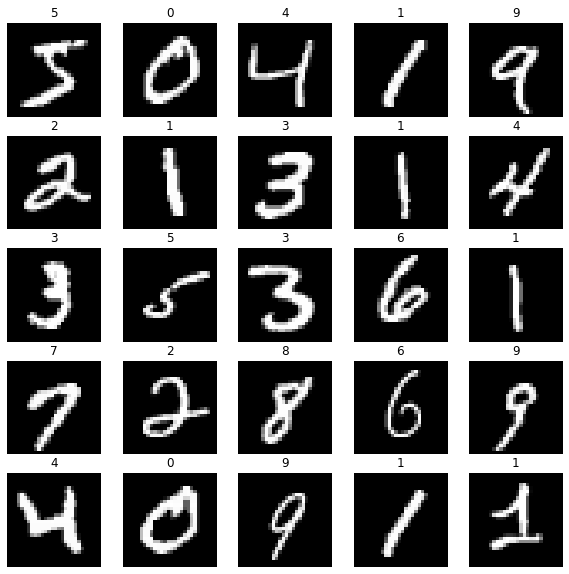

In [51]:
show_images(train_dataset)

In [0]:
MAX_NUMBER_LENGTH = 5

In [0]:
def generate_synt_data(max_number_length, dataset):
    images, labels = dataset
    images_len, height, width, _ = images.shape
    synt_x, synt_y = [], []
    for _ in range(images_len):
        image = np.zeros((height, width * max_number_length))
        length = random.randint(1, max_number_length)
        offset = random.randint(0, max_number_length - length)
        number_labels = [10] * max_number_length
        for pos in range(offset, offset + length):
            image_id = random.randint(0, images_len - 1)
            img = images[image_id]
            img = img.reshape((width, height))
            image[:, pos * width: pos * width + width] = img
            number_labels[pos] = labels[image_id]
        synt_y.append(number_labels)
        synt_x.append(image.reshape((height, width * max_number_length,  1)))
    return np.array(synt_x), np.array(synt_y)

val_size = 1000
synt_train_x, synt_train_y = generate_synt_data(MAX_NUMBER_LENGTH, train_dataset)
synt_val_x, synt_val_y = synt_train_x[:val_size], synt_train_y[:val_size]
synt_train_x, synt_train_y = synt_train_x[val_size:], synt_train_y[val_size:]
synt_test_x, synt_test_y = generate_synt_data(5, test_dataset)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


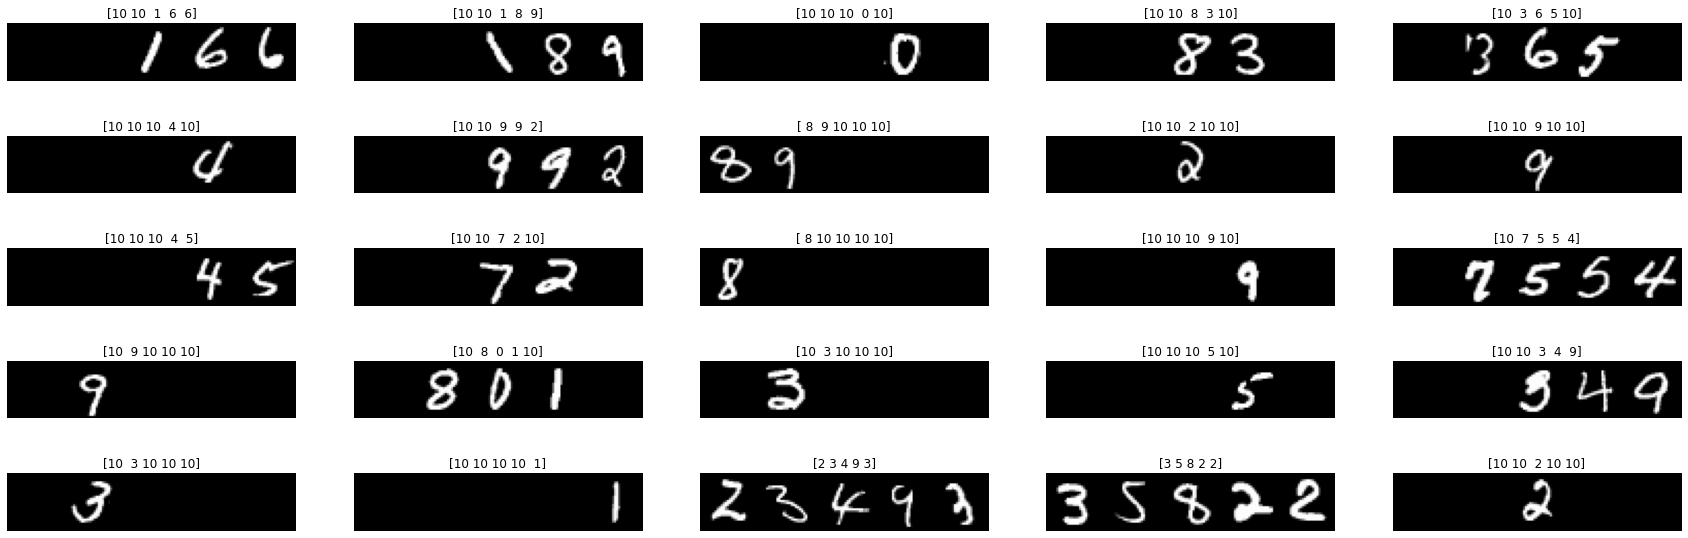

In [53]:
show_images((synt_val_x, synt_val_y), figsize=(30, 10))

В качестве модели будем использовать можель описанную статье (http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf)

In [0]:
def get_model(input_shape=(28, 28 * MAX_NUMBER_LENGTH, 1), p=0.5, n_class=11):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Conv2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p/4)(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p/4)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p/2)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p/2)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p)(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)

    o1 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o2 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o3 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o4 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o5 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=[o1, o2, o3, o4, o5])

    return model

In [99]:
model = Model(model=get_model())
model.compile(optimizer='adam')

----------------------------------------------------------------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 140, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 28, 140, 1)   4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 140, 48)  1248        batch_normalization_8[0][0]      
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 14, 70, 48)   0           conv2d_8[0][0]                   
___

In [0]:
BATCH_SIZE = 128

In [0]:
def value_transpose(y, max_len=MAX_NUMBER_LENGTH):
    return [y.T[i] for i in range(max_len)]

In [100]:
synt_train_ys = value_transpose(synt_train_y)
synt_val_ys = value_transpose(synt_val_y)

history = model.model.fit(synt_train_x, synt_train_ys, batch_size=BATCH_SIZE, epochs=5, validation_data=(synt_val_x, synt_val_ys))

Epoch 1/5
461/461 [==============================] - 27s 58ms/step - loss: 2.9640 - dense_10_loss: 0.4923 - dense_11_loss: 0.6380 - dense_12_loss: 0.6882 - dense_13_loss: 0.6280 - dense_14_loss: 0.5176 - dense_10_accuracy: 0.8207 - dense_11_accuracy: 0.7665 - dense_12_accuracy: 0.7445 - dense_13_accuracy: 0.7662 - dense_14_accuracy: 0.8179 - val_loss: 5.5725 - val_dense_10_loss: 0.4987 - val_dense_11_loss: 1.8619 - val_dense_12_loss: 0.9042 - val_dense_13_loss: 0.8369 - val_dense_14_loss: 1.4709 - val_dense_10_accuracy: 0.7860 - val_dense_11_accuracy: 0.6300 - val_dense_12_accuracy: 0.7130 - val_dense_13_accuracy: 0.7000 - val_dense_14_accuracy: 0.5960
Epoch 2/5
461/461 [==============================] - 25s 55ms/step - loss: 0.2379 - dense_10_loss: 0.0415 - dense_11_loss: 0.0474 - dense_12_loss: 0.0512 - dense_13_loss: 0.0511 - dense_14_loss: 0.0468 - dense_10_accuracy: 0.9888 - dense_11_accuracy: 0.9880 - dense_12_accuracy: 0.9872 - dense_13_accuracy: 0.9876 - dense_14_accuracy: 0.98

In [0]:
import operator

def set_legend(ax):
    handles, labels = ax.get_legend_handles_labels()

    # reverse the order
    ax.legend(handles[::-1], labels[::-1])

    # or sort them by labels
    hl = sorted(zip(handles, labels),
                key=operator.itemgetter(1))
    handles2, labels2 = zip(*hl)

    ax.legend(handles2, labels2)

def plot_history(history):
    plt.figure(figsize=(24,8))

    ax1 = plt.subplot(1, 2, 1)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)

    for key, values in history.history.items():
        if 'loss' in key:
            line, = ax1.plot(values, label=key)
            # line.set_label(key)
        else:
            line, = ax2.plot(values, label=key)
            # line.set_label(key)

    set_legend(ax1)
    set_legend(ax2)

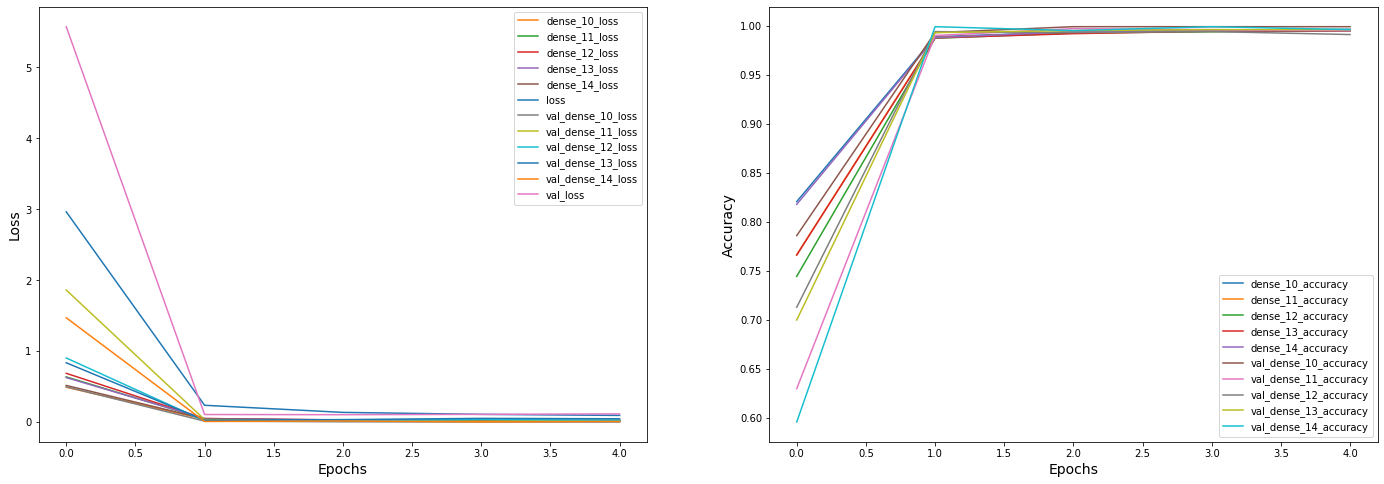

In [101]:
plot_history(history)

In [102]:
synt_test_ys = value_transpose(synt_test_y)
model.test(synt_test_x, synt_test_ys)

313/313 [==============================] - 3s 9ms/step - loss: 0.1893 - dense_10_loss: 0.0246 - dense_11_loss: 0.0388 - dense_12_loss: 0.0565 - dense_13_loss: 0.0412 - dense_14_loss: 0.0282 - dense_10_accuracy: 0.9960 - dense_11_accuracy: 0.9939 - dense_12_accuracy: 0.9889 - dense_13_accuracy: 0.9936 - dense_14_accuracy: 0.9955


[0.18927954137325287,
 0.024623006582260132,
 0.038793593645095825,
 0.0564599446952343,
 0.041240546852350235,
 0.028162401169538498,
 0.9959999918937683,
 0.9939000010490417,
 0.9889000058174133,
 0.9936000108718872,
 0.9955000281333923]

In [0]:
test_pred = model.model.predict(synt_test_x)

Pediction: 0 0 1 4 6


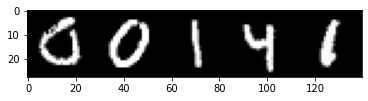

In [104]:
elem = 100
elem_prediction = [str(np.argmax(test_pred[i][elem])) for i in range(MAX_NUMBER_LENGTH)]
print('Pediction:', ' '.join(elem_prediction))
plt.imshow(synt_test_x[elem][:, :, 0], cmap='gray')

Модель показала себя неплохо. Индивидуальные предсказания оказались на высоком уровне.

### Задание 2.После уточнения модели на синтетических данных попробуйте обучить ее на реальных данных (набор Google Street View). Что изменилось в модели?

In [0]:
import tarfile
!rm -rf /content/google
!mkdir /content/google

In [0]:
with tarfile.open(f'{DRIVE_DIR}google_images/train.tar.gz') as f:
    f.extractall('/content/google')

In [0]:
with tarfile.open(f'{DRIVE_DIR}google_images/test.tar.gz') as f:
    f.extractall('/content/google')

In [0]:
train_dir = pathlib.Path('/content/google/train/')
test_dir = pathlib.Path('/content/google/test/')

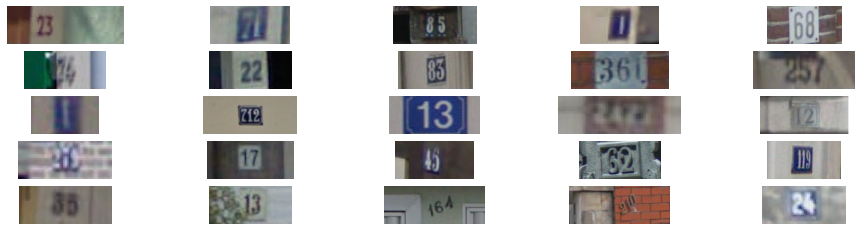

In [12]:
f = plt.figure(figsize=(16, 4))

for i, fn in enumerate(np.random.choice(list(train_dir.glob('*.png')), 25)):
    f.add_subplot(5, 5, i + 1)
    plt.imshow(Image.open(fn, mode='r'))
    plt.axis('off')

plt.show()

Стоит заметить, что картинки не одного размера. Проанализируем их размеры:

In [0]:
sizes = []
for filepath in list(train_dir.glob('*.png')):
    image = Image.open(str(filepath))
    image = np.asarray(image)
    height, width, _ = image.shape
    sizes.append([height, width, filepath])

sizes = np.array(sizes)

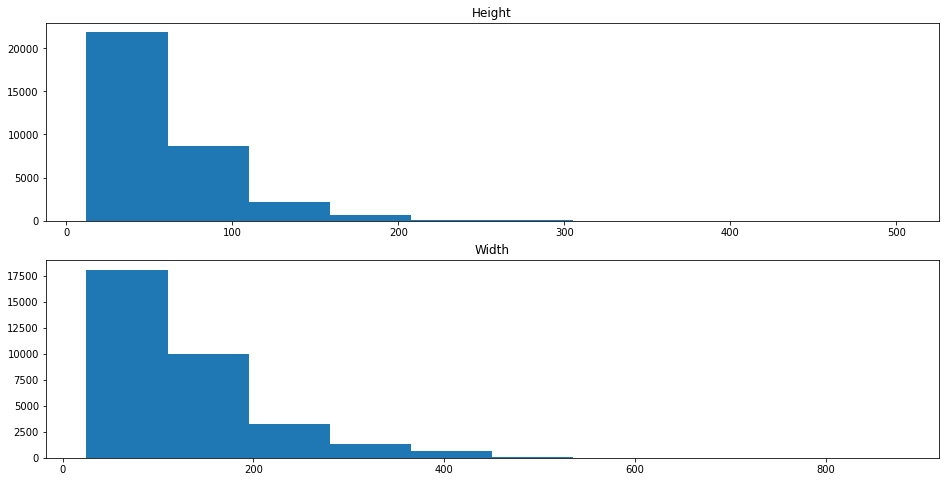

In [14]:
f = plt.figure(figsize=(16, 8))
ax = f.add_subplot(2, 1, 1)
ax.hist(sizes[:, 0])
ax.set_title("Height")
ax = f.add_subplot(2, 1, 2)
ax.hist(sizes[:, 1])
ax.set_title("Width")
plt.show()

Как видно из графиков, большая часть картинок имеют высоту до ~50 пикилей и ширину до ~100 пиксилей.

0.4499521751120962

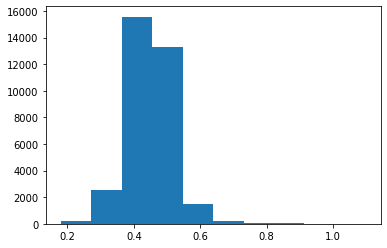

In [15]:
ratios = [s[0] / s[1] for s in sizes]
plt.hist(ratios)
np.mean(ratios)

Среднее соотношение сторон в выборке ~0.45

Подберем наилучшие размеры изображений исходя из графиков.

К сожалению, самые направшивающиеся значения (45, 100) не подойдут, т.к. модель, которую мы будем использовать дальше, требует больших размеров входного слоя.

Первыми подходщими целыми значениями с выбранным соотношением (0.5), являются (54, 120).

In [0]:
IMAGE_HEIGHT, IMAGE_WIDTH = 54, 120

In [0]:
!rm -rf /content/google/train_resized/
!rm -rf /content/google/test_resized/

Далее необходимо привести все изображения к одному размеру.

In [0]:
def resize(image, result_height, result_width):
    height, width, _ = image.shape
    rate = height / result_height
    target_width = int(width / rate)
    if target_width < result_width:
        rate = width / result_width
        target_height = int(height / rate)
        img = tf.image.resize(image, (target_height, result_width))
    else:
        img = tf.image.resize(image, (result_height, target_width))
    return tf.image.random_crop(img, (result_height, result_width, 3))

def resize_image_dataset(folder):
    result_dir = pathlib.Path(f'/content/google/{folder}_resized/')
    result_dir.mkdir(parents=True, exist_ok=True)
    for filepath in pathlib.Path(f'/content/google/{folder}').glob('*.png'):
        try:
            image = Image.open(str(filepath))
            array = np.asarray(image)
            array = resize(array, IMAGE_HEIGHT, IMAGE_WIDTH)
            image = tf.keras.preprocessing.image.array_to_img(array)
            image.save(f'{str(result_dir)}/{filepath.name}')
        except:
            continue

In [0]:
resize_image_dataset("train")
resize_image_dataset("test")

In [0]:
train_resized_dir = pathlib.Path('/content/google/train_resized/')
test_resized_dir = pathlib.Path('/content/google/test_resized/')

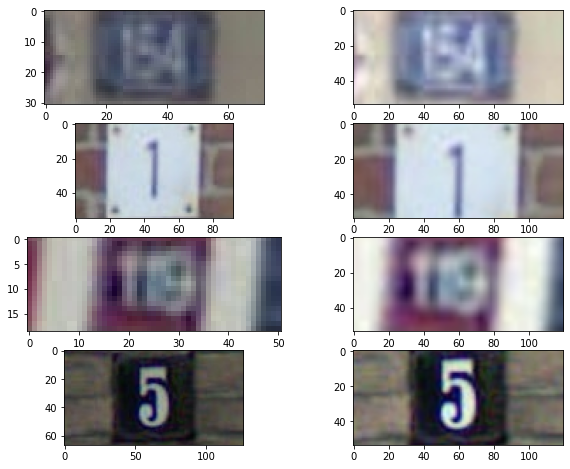

In [21]:
f = plt.figure(figsize=(10, 8))
i = 0

for path in np.random.choice(list(train_dir.glob('*.png')), 4):
    f.add_subplot(4, 2, i + 1)
    plt.imshow(Image.open(path, mode='r'))
    f.add_subplot(4, 2, i + 2)
    plt.imshow(Image.open(f'{train_resized_dir}/{path.name}', mode='r'))
    i += 2

plt.show()

Левая колонка с исходными изображениями, колонка справа с картинками, приведенными к одинковым размерам.

Теперь выясним какие числа изображены на картинках. А также замапим их на сами картинки для обучения и тестирования.

In [0]:
import h5py

In [0]:
def zip_google_images_with_labels(digit_struct_filepath, images_folder, max_label_length):
    with h5py.File(digit_struct_filepath, 'r') as f:
        name = f['/digitStruct/name']
        bbox = f['/digitStruct/bbox']
        
        def get_name(f, i):
            return ''.join([chr(v[0]) for v in f[name[i][0]]])

        def get_label(f, i):
            label_attr = f[bbox[i].item()]["label"]
            if len(label_attr) > 1:
                attr = [int(f[label_attr[j].item()][0][0]) for j in range(len(label_attr))]
            else:
                attr = [int(label_attr[0][0])]
            return attr

        size = len(name)
        data = []
        for i in range(size):
            image_name = get_name(f, i)
            try:
                image = Image.open(images_folder + "/" + image_name)
                array = np.asarray(image)
            except:
                print(images_folder + "/" + image_name + '- not found')
                continue

            height, width, _ = array.shape
            array = np.mean(array, axis=2).reshape((height, width, 1)) / 255
            labels = list(get_label(f, i))
            label_len = len(labels)

            if label_len > max_label_length:
                continue
            else:
                labels.extend([10] * (max_label_length - label_len))

            labels.append(label_len)
            data.append([array, labels])
        return np.array(data)

In [0]:
google_train_data = zip_google_images_with_labels(f'{train_dir}/digitStruct.mat', str(train_resized_dir), MAX_NUMBER_LENGTH)

In [0]:
google_test_data = zip_google_images_with_labels(f'{test_dir}/digitStruct.mat', str(test_resized_dir), MAX_NUMBER_LENGTH)

In [0]:
validation_len = int(len(google_train_data) * 0.05)
random.shuffle(google_train_data)
google_validation_data = google_train_data[:validation_len]
google_train_data = google_train_data[validation_len:]

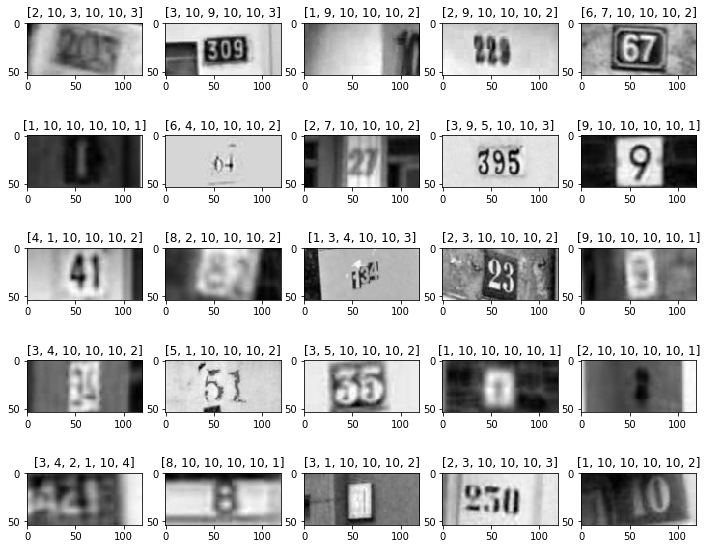

In [32]:
fig = plt.figure(figsize=(12, 10))
for i in range(1, 26):
    img, label = random.choice(google_train_data)
    ax = fig.add_subplot(5, 5, i)
    ax.set_title(label)
    plt.imshow(img[:, :, 0], interpolation='nearest', cmap='gray')

Построим модель с 6-ю выходными узлами:

In [0]:
def get_model_with_length(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1), p=0.5, n_class=11):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Conv2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p/4)(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p/4)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p/2)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p/2)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p)(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(3072, activation='relu')(x)
    x = tf.keras.layers.Dense(3072, activation='relu')(x)

    l = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    d1 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    d2 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    d3 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    d4 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    d5 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=[d1, d2, d3, d4, d5, l])

    return model

In [105]:
model = Model(model=get_model_with_length())
model.compile(optimizer='adam')

----------------------------------------------------------------------------------------
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 54, 120, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 54, 120, 1)   4           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 54, 120, 48)  1248        batch_normalization_14[0][0]     
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 27, 60, 48)   0           conv2d_14[0][0]                  
___

In [0]:
def unzip(tuples):
    first = [t[0] for t in tuples]
    second = [t[1] for t in tuples]
    return np.array(first), np.array(second)

google_train_x, google_train_y = unzip(google_train_data)
google_train_y = value_transpose(google_train_y, MAX_NUMBER_LENGTH + 1)

google_validation_x, google_validation_y = unzip(google_validation_data)
google_validation_y = value_transpose(google_validation_y, MAX_NUMBER_LENGTH + 1)

google_test_x, google_test_y = unzip(google_test_data)
google_test_y = value_transpose(google_test_y, MAX_NUMBER_LENGTH + 1)

In [106]:
history = model.model.fit(google_train_x, google_train_y,
                          batch_size=BATCH_SIZE, epochs=20,
                          validation_data=(google_validation_x, google_validation_y))

Epoch 1/20
248/248 [==============================] - 21s 86ms/step - loss: 7.0042 - dense_18_loss: 2.1013 - dense_19_loss: 2.2555 - dense_20_loss: 1.2244 - dense_21_loss: 0.2651 - dense_22_loss: 0.0148 - dense_17_loss: 1.1431 - dense_18_accuracy: 0.2614 - dense_19_accuracy: 0.2505 - dense_20_accuracy: 0.7260 - dense_21_accuracy: 0.9600 - dense_22_accuracy: 0.9962 - dense_17_accuracy: 0.5332 - val_loss: 7.2199 - val_dense_18_loss: 2.0018 - val_dense_19_loss: 2.2400 - val_dense_20_loss: 1.3530 - val_dense_21_loss: 0.3978 - val_dense_22_loss: 0.0137 - val_dense_17_loss: 1.2135 - val_dense_18_accuracy: 0.2784 - val_dense_19_accuracy: 0.2168 - val_dense_20_accuracy: 0.7689 - val_dense_21_accuracy: 0.9593 - val_dense_22_accuracy: 1.0000 - val_dense_17_accuracy: 0.3940
Epoch 2/20
248/248 [==============================] - 21s 84ms/step - loss: 6.1216 - dense_18_loss: 1.9650 - dense_19_loss: 2.0937 - dense_20_loss: 1.0401 - dense_21_loss: 0.2061 - dense_22_loss: 0.0011 - dense_17_loss: 0.8155

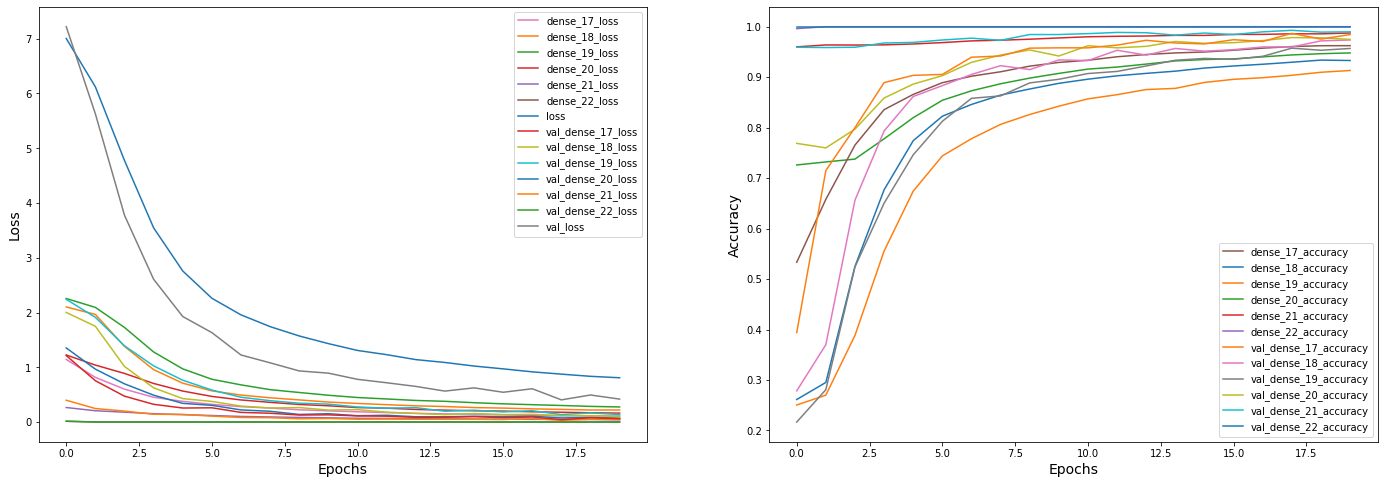

In [107]:
plot_history(history)

In [108]:
model.test(google_test_x, google_test_y)

409/409 [==============================] - 5s 12ms/step - loss: 3.4360 - dense_18_loss: 1.1309 - dense_19_loss: 1.2031 - dense_20_loss: 0.4348 - dense_21_loss: 0.0544 - dense_22_loss: 9.5138e-04 - dense_17_loss: 0.6118 - dense_18_accuracy: 0.7147 - dense_19_accuracy: 0.6856 - dense_20_accuracy: 0.9003 - dense_21_accuracy: 0.9907 - dense_22_accuracy: 0.9999 - dense_17_accuracy: 0.8140


[3.4360153675079346,
 1.1308999061584473,
 1.2031296491622925,
 0.4348357915878296,
 0.05443602055311203,
 0.0009513817494735122,
 0.6117630004882812,
 0.7147229909896851,
 0.6856443285942078,
 0.9002907872200012,
 0.9907407164573669,
 0.9999234676361084,
 0.8140496015548706]

In [0]:
google_test_pred = model.model.predict(google_test_x)

Pediction: 3 6 10 10 10 2


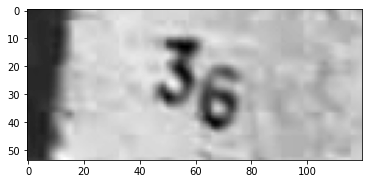

In [112]:
elem = 101
elem_prediction = [str(np.argmax(google_test_pred[i][elem])) for i in range(MAX_NUMBER_LENGTH + 1)]
print('Pediction:', ' '.join(elem_prediction))
plt.imshow(google_test_x[elem][:, :, 0], cmap='gray')

### Задание 3. Сделайте множество снимков изображений номеров домов с помощью смартфона на ОС Android. Также можно использовать библиотеки OpenCV, Simple CV или Pygame для обработки изображений с общедоступных камер видеонаблюдения (например, https://www.earthcam.com/). Пример использования библиотеки TensorFlow на смартфоне можете воспользоваться демонстрационным приложением от Google (https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android).


In [54]:
real_data_dir = pathlib.Path(f'{DRIVE_DIR}real_images')

real_image_count = len(list(real_data_dir.glob('*.jpg')))
real_image_count

12

In [0]:
images = []
for path in real_data_dir.glob('*.jpg'):
    image = Image.open(path)
    array = np.asarray(image)
    array = resize(array, IMAGE_HEIGHT, IMAGE_WIDTH)
    height, width, _ = array.shape
    array = np.mean(array, axis=2).reshape((height, width, 1)) / 255
    images.append(array)

images = np.array(images)

In [93]:
images.shape

(12, 54, 120, 1)

### Задание 4. Реализуйте приложение для ОС Android, которое может распознавать цифры в номерах домов, используя разработанный ранее классификатор. Какова доля правильных классификаций?

In [0]:
predictions = model.model.predict(images)

In [0]:
predictions[0][0].shape
calc_predcitions = []
for i in range(len(images)):
    pred = []
    for d in range(MAX_NUMBER_LENGTH + 1):
        pred.append(np.argmax(predictions[d][i]))

    calc_predcitions.append(pred)

In [124]:
calc_predcitions

[[3, 10, 10, 10, 10, 1],
 [1, 1, 10, 10, 10, 2],
 [5, 3, 10, 10, 10, 2],
 [3, 6, 10, 10, 10, 2],
 [1, 10, 10, 10, 10, 1],
 [7, 2, 10, 10, 10, 2],
 [3, 7, 10, 10, 10, 2],
 [1, 10, 10, 10, 10, 1],
 [1, 10, 10, 10, 10, 2],
 [4, 10, 10, 10, 10, 1],
 [5, 10, 10, 10, 10, 1],
 [3, 4, 5, 10, 10, 3]]

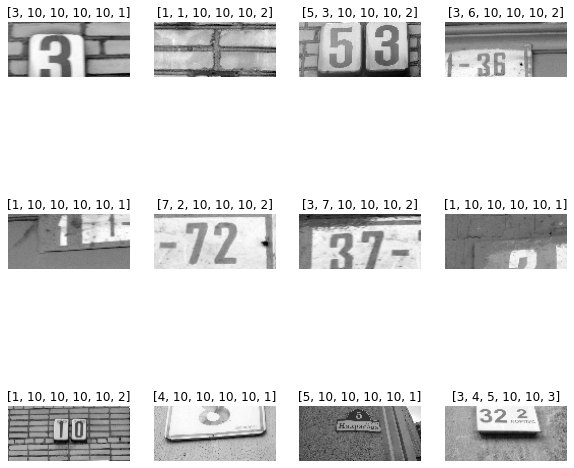

In [125]:
plt.figure(figsize=(10,10))
for i in range(len(images)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.title(calc_predcitions[i])
    plt.axis('off')


За счет того, что картинку имеют большое разрешение и при ресайзе качество теряется за счет обрезания картинки, то глядя на полученные результаты, я бы сказал, что классификатор работает неплохо. Еденственное стоило бы еще поработать над обработкой входных данных.